# PyGGM: Complete Tutorial - Correct Implementation

**A comprehensive guide to Gaussian Graphical Models using PyGGM with proper statistical methods**

This notebook demonstrates the **correct workflow** for non-Gaussian data:
1. **Check normality** - Test if data is Gaussian
2. **Transform if needed** - Apply Nonparanormal (NPN) transformation for non-Gaussian data
3. **Fit models** - Use multiple methods (StARS, EBIC, CV)
4. **Comprehensive visualization** - Understand and compare results

## Table of Contents

1. [Setup and Data Loading](#setup)
2. [Normality Testing (CRITICAL!)](#normality)
3. [Nonparanormal Transformation](#transform)
4. [Method Comparison](#methods)
   - StARS (Stability Selection)
   - EBIC (Extended BIC)
   - Cross-Validation
5. [Advanced Visualizations](#viz)
6. [Fixed Alpha Analysis](#fixed-alpha)
7. [Bootstrap Stability](#bootstrap)
8. [Summary and Best Practices](#summary)

<a id='setup'></a>
## 1. Setup and Data Loading

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Import PyGGM
from pyggm import GaussianGraphicalModel, Nonparanormal
from pyggm.visualization import (
    plot_network, 
    plot_precision_matrix,
    plot_stars_path,
    plot_edge_stability,
    plot_regularization_path,
    plot_model_selection
)

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load flow cytometry data
data = pd.read_csv('flow_cytometry_data.csv')
X_raw = data.values
feature_names = data.columns.tolist()
n_samples, n_features = X_raw.shape

print(f"Dataset: {n_samples} samples × {n_features} features")
print(f"\nFeatures: {', '.join(feature_names)}")
print(f"\n{data.head()}")

Dataset: 7466 samples × 11 features

Features: praf, pmek, plcg, PIP2, PIP3, P44, pakts, PKA, PKC, P38, pjnk

       praf       pmek      plcg      PIP2       PIP3        P44     pakts  \
0 -97.67193 -132.18100 -46.03364 -132.8207  31.765040 -20.021190 -64.16721   
1 -88.17193 -128.88100 -42.55364 -134.3207 -18.904960  -8.031193 -48.66721   
2 -64.67193 -101.28100 -40.25364 -140.9207 -14.034960 -11.731190 -48.66721   
3 -51.07193  -62.58096 -31.75364 -137.6207 -25.744960 -20.801190 -69.36721   
4 -90.37193 -125.58100 -49.66364 -141.3907  -2.234962  -5.531193 -35.06721   

         PKA       PKC       P38       pjnk  
0 -211.75860 -13.34166  -90.1145 -33.267500  
1 -273.75860 -26.97166 -118.5145 -11.767500  
2 -222.75860 -18.94166 -103.1145 -53.767500  
3  -97.75859 -16.64166 -106.4145 -50.167500  
4 -320.75860 -25.68166 -109.3145   8.032497  


<a id='normality'></a>
## 2. Normality Testing 
**IMPORTANT**: Gaussian Graphical Models assume multivariate Gaussian data!

We MUST check normality before proceeding. If data is non-Gaussian, we need to:
1. Apply Nonparanormal (NPN) transformation, OR
2. Use rank correlations (Spearman/Kendall)

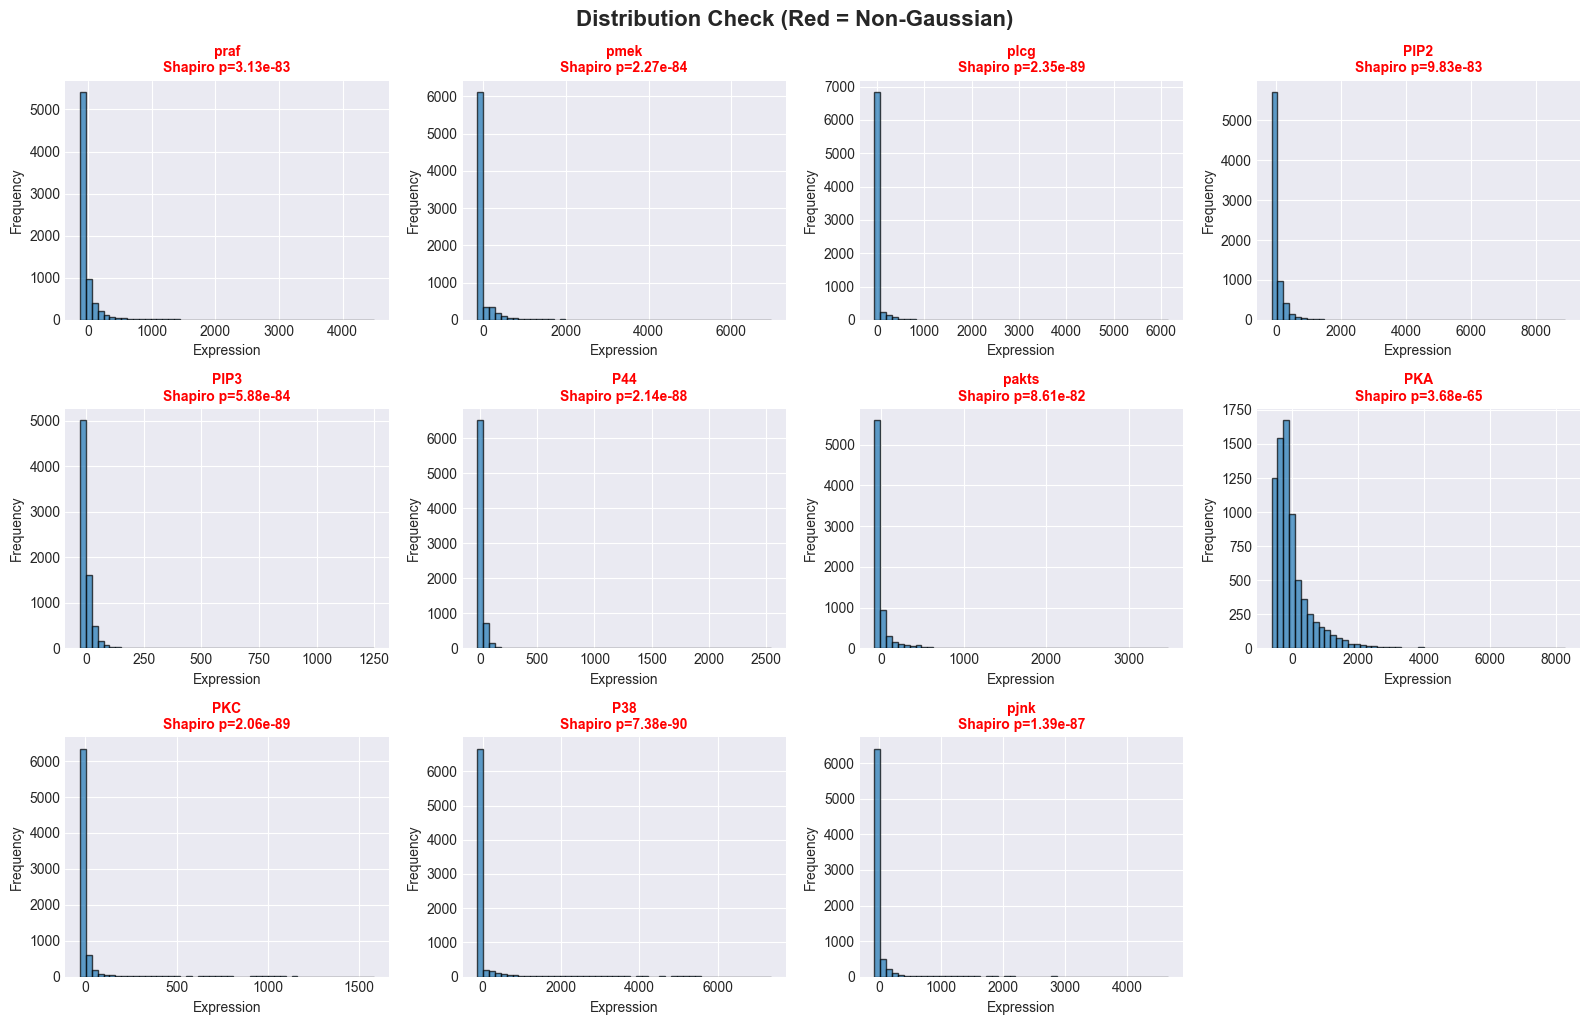


NORMALITY TEST RESULTS (α=0.05)
Gaussian variables: 0/11
Non-Gaussian variables: 11/11

⚠️  CONCLUSION: Data is clearly NON-GAUSSIAN!
    → We MUST use transformation or rank correlation


In [ ]:
# Visualize distributions and test normality
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

normality_results = []

for i, col in enumerate(data.columns):
    # Histogram
    axes[i].hist(data[col], bins=50, edgecolor='black', alpha=0.7)
    
    # Shapiro-Wilk test (sample if too large)
    sample_size = min(5000, len(data))
    sample = data[col].sample(sample_size, random_state=42)
    stat, pval = stats.shapiro(sample)
    
    is_normal = pval > 0.05
    normality_results.append(is_normal)
    
    # Color: green if normal, red if not
    color = 'green' if is_normal else 'red'
    axes[i].set_title(f'{col}\nShapiro p={pval:.2e}', 
                     fontsize=10, fontweight='bold', color=color)
    axes[i].set_xlabel('Expression')
    axes[i].set_ylabel('Frequency')

fig.delaxes(axes[11])
plt.tight_layout()
plt.suptitle('Distribution Check (Red = Non-Gaussian)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"\n{'='*70}")
print(f"NORMALITY TEST RESULTS (α=0.05)")
print(f"{'='*70}")
print(f"Gaussian variables: {sum(normality_results)}/{len(normality_results)}")
print(f"Non-Gaussian variables: {len(normality_results) - sum(normality_results)}/{len(normality_results)}")
print(f"\nCONCLUSION: Data is clearly NON-GAUSSIAN!")
print(f"    → We MUST use transformation or rank correlation")
print(f"{'='*70}")

<a id='transform'></a>
## 3. Nonparanormal Transformation

Since our data is non-Gaussian, we apply the **Nonparanormal (NPN)** transformation:
1. Rank transform each variable
2. Map to uniform distribution via ECDF
3. Apply inverse Gaussian CDF (Φ⁻¹)

This makes the data approximately Gaussian while preserving monotonic relationships.

In [ ]:
# Apply NPN transformation
npn = Nonparanormal()
X_transformed = npn.fit_transform(X_raw)

print("Applied Nonparanormal transformation")
print(f"  Original data: {X_raw.shape}")
print(f"  Transformed data: {X_transformed.shape}")

✓ Applied Nonparanormal transformation
  Original data: (7466, 11)
  Transformed data: (7466, 11)


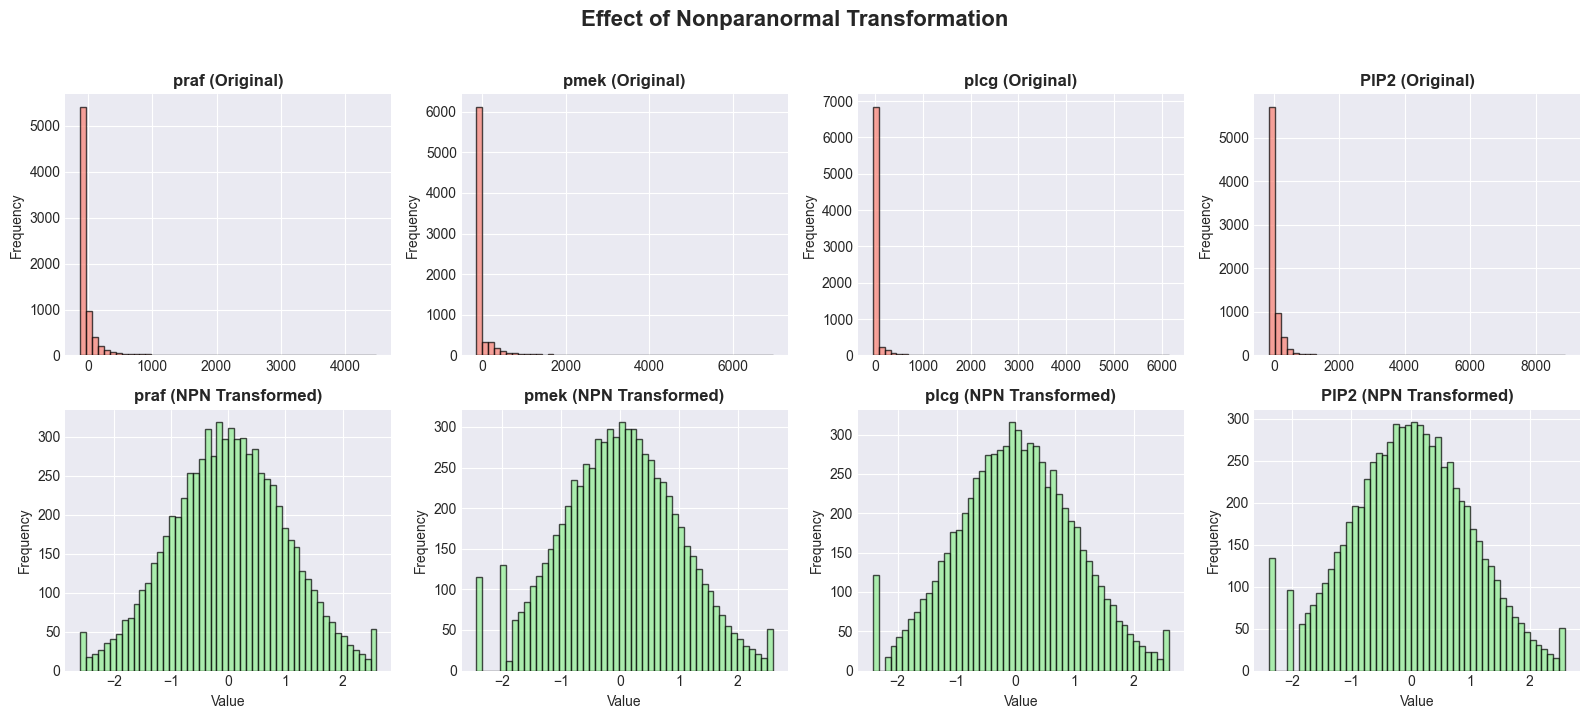

✓ Transformation makes distributions more Gaussian-like


In [ ]:
# Compare before and after transformation
fig, axes = plt.subplots(2, 4, figsize=(16, 7))

# Show 4 example proteins
examples = [0, 1, 2, 3]

for idx, i in enumerate(examples):
    # Original (non-Gaussian)
    axes[0, idx].hist(X_raw[:, i], bins=50, edgecolor='black', alpha=0.7, color='salmon')
    axes[0, idx].set_title(f'{feature_names[i]} (Original)', fontweight='bold')
    axes[0, idx].set_ylabel('Frequency')
    
    # NPN transformed (approximately Gaussian)
    axes[1, idx].hist(X_transformed[:, i], bins=50, edgecolor='black', 
                     alpha=0.7, color='lightgreen')
    axes[1, idx].set_title(f'{feature_names[i]} (NPN Transformed)', fontweight='bold')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].set_xlabel('Value')

plt.suptitle('Effect of Nonparanormal Transformation', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Transformation makes distributions more Gaussian-like")

<a id='methods'></a>
## 4. Method Comparison

We'll compare three regularization selection methods on the **transformed** data:

1. **StARS** - Stability Approach to Regularization Selection
   - Most conservative (fewest edges)
   - Best for reproducibility
   - Minimizes false positives

2. **EBIC** - Extended Bayesian Information Criterion
   - Balances model fit and sparsity
   - Fast and interpretable
   - Good for exploration

3. **Cross-Validation**
   - Optimizes predictive performance
   - May include more edges
   - Standard ML approach

### 4.1 StARS (Stability Selection)

In [6]:
print("Fitting StARS on NPN-transformed data...\n")

model_stars = GaussianGraphicalModel(
    method='stars',
    beta=0.05,
    n_subsamples=50,
    n_alphas=30,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

model_stars.fit(X_transformed)  # ← Using TRANSFORMED data!

print(f"\n{'='*80}")
print(f"StARS Results (on NPN-transformed data):")
print(f"  Selected λ: {model_stars.alpha_:.6f}")
print(f"  Number of edges: {model_stars.n_edges_}")
print(f"  Network density: {model_stars.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"  Sparsity: {1 - model_stars.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"{'='*80}")

Fitting StARS on NPN-transformed data...

Fitting GaussianGraphicalModel: n=7466, p=11, method=stars, correlation=pearson
StARS: n=7466, p=11, subsample_size=3733, n_subsamples=50, beta=0.05
StARS: Evaluating alpha 1/30: 0.007655
  Instability: 0.0632, Avg edges: 51.0
StARS: Evaluating alpha 2/30: 0.008972
  Instability: 0.0610, Avg edges: 49.0
StARS: Evaluating alpha 3/30: 0.010516
  Instability: 0.0578, Avg edges: 49.0
StARS: Evaluating alpha 4/30: 0.012326
  Instability: 0.0612, Avg edges: 48.0
StARS: Evaluating alpha 5/30: 0.014448
  Instability: 0.0624, Avg edges: 48.0
StARS: Evaluating alpha 6/30: 0.016934
  Instability: 0.0661, Avg edges: 49.0
StARS: Evaluating alpha 7/30: 0.019848
  Instability: 0.0872, Avg edges: 49.0
StARS: Evaluating alpha 8/30: 0.023264
  Instability: 0.0803, Avg edges: 46.0
StARS: Evaluating alpha 9/30: 0.027268
  Instability: 0.0733, Avg edges: 47.0
StARS: Evaluating alpha 10/30: 0.031961
  Instability: 0.0765, Avg edges: 47.0
StARS: Evaluating alpha 11/3

### 4.2 EBIC (Extended BIC)

In [7]:
print("Fitting EBIC on NPN-transformed data...\n")

model_ebic = GaussianGraphicalModel(
    method='ebic',
    gamma=0.5,
    n_alphas=30,
    n_jobs=-1,
    verbose=1
)

model_ebic.fit(X_transformed)  # ← Using TRANSFORMED data!

print(f"\n{'='*80}")
print(f"EBIC Results (on NPN-transformed data):")
print(f"  Selected λ: {model_ebic.alpha_:.6f}")
print(f"  Number of edges: {model_ebic.n_edges_}")
print(f"  Network density: {model_ebic.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"  Sparsity: {1 - model_ebic.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"{'='*80}")

Fitting EBIC on NPN-transformed data...

Fitting GaussianGraphicalModel: n=7466, p=11, method=ebic, correlation=pearson
EBIC: Fitting alpha 1/30: 0.007655
EBIC: Fitting alpha 2/30: 0.008972
EBIC: Fitting alpha 3/30: 0.010516
EBIC: Fitting alpha 4/30: 0.012326
EBIC: Fitting alpha 5/30: 0.014448
EBIC: Fitting alpha 6/30: 0.016934
EBIC: Fitting alpha 7/30: 0.019848
EBIC: Fitting alpha 8/30: 0.023264
EBIC: Fitting alpha 9/30: 0.027268
EBIC: Fitting alpha 10/30: 0.031961
EBIC: Fitting alpha 11/30: 0.037462
EBIC: Fitting alpha 12/30: 0.043909
EBIC: Fitting alpha 13/30: 0.051466
EBIC: Fitting alpha 14/30: 0.060323
EBIC: Fitting alpha 15/30: 0.070705
EBIC: Fitting alpha 16/30: 0.082873
EBIC: Fitting alpha 17/30: 0.097136
EBIC: Fitting alpha 18/30: 0.113853
EBIC: Fitting alpha 19/30: 0.133447
EBIC: Fitting alpha 20/30: 0.156414
EBIC: Fitting alpha 21/30: 0.183333
EBIC: Fitting alpha 22/30: 0.214885
EBIC: Fitting alpha 23/30: 0.251868
EBIC: Fitting alpha 24/30: 0.295215
EBIC: Fitting alpha 25/30

### 4.3 Cross-Validation

In [8]:
print("Fitting CV on NPN-transformed data...\n")

model_cv = GaussianGraphicalModel(
    method='cv',
    cv=5,
    n_alphas=20,
    n_jobs=-1,
    verbose=1
)

model_cv.fit(X_transformed)  # ← Using TRANSFORMED data!

print(f"\n{'='*80}")
print(f"CV Results (on NPN-transformed data):")
print(f"  Selected λ: {model_cv.alpha_:.6f}")
print(f"  Number of edges: {model_cv.n_edges_}")
print(f"  Network density: {model_cv.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"  Sparsity: {1 - model_cv.n_edges_/(n_features*(n_features-1)/2):.1%}")
print(f"{'='*80}")

Fitting CV on NPN-transformed data...

Fitting GaussianGraphicalModel: n=7466, p=11, method=cv, correlation=pearson


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


Fit complete: alpha=0.025719, n_edges=46

CV Results (on NPN-transformed data):
  Selected λ: 0.025719
  Number of edges: 46
  Network density: 83.6%
  Sparsity: 16.4%


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


### 4.4 Method Comparison Summary

In [9]:
# Comparison table
comparison = pd.DataFrame({
    'Method': ['StARS', 'EBIC', 'CV'],
    'Lambda': [model_stars.alpha_, model_ebic.alpha_, model_cv.alpha_],
    'Edges': [model_stars.n_edges_, model_ebic.n_edges_, model_cv.n_edges_],
    'Density': [
        f"{model_stars.n_edges_/(n_features*(n_features-1)/2):.1%}",
        f"{model_ebic.n_edges_/(n_features*(n_features-1)/2):.1%}",
        f"{model_cv.n_edges_/(n_features*(n_features-1)/2):.1%}"
    ]
})

print("\n" + "="*70)
print("METHOD COMPARISON (All on NPN-transformed data)")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)
print("\nKey Insights:")
print("  • StARS is most conservative (fewer edges)")
print("  • EBIC and CV balance sparsity and fit")
print("  • All methods use CORRECT transformation")


METHOD COMPARISON (All on NPN-transformed data)
Method   Lambda  Edges Density
 StARS 0.156414     26   47.3%
  EBIC 0.007655     50   90.9%
    CV 0.025719     46   83.6%

Key Insights:
  • StARS is most conservative (fewer edges)
  • EBIC and CV balance sparsity and fit
  • All methods use CORRECT transformation


<a id='viz'></a>
## 5. Advanced Visualizations

Now let's create comprehensive visualizations for each method.

### 5.1 StARS Comprehensive Visualization

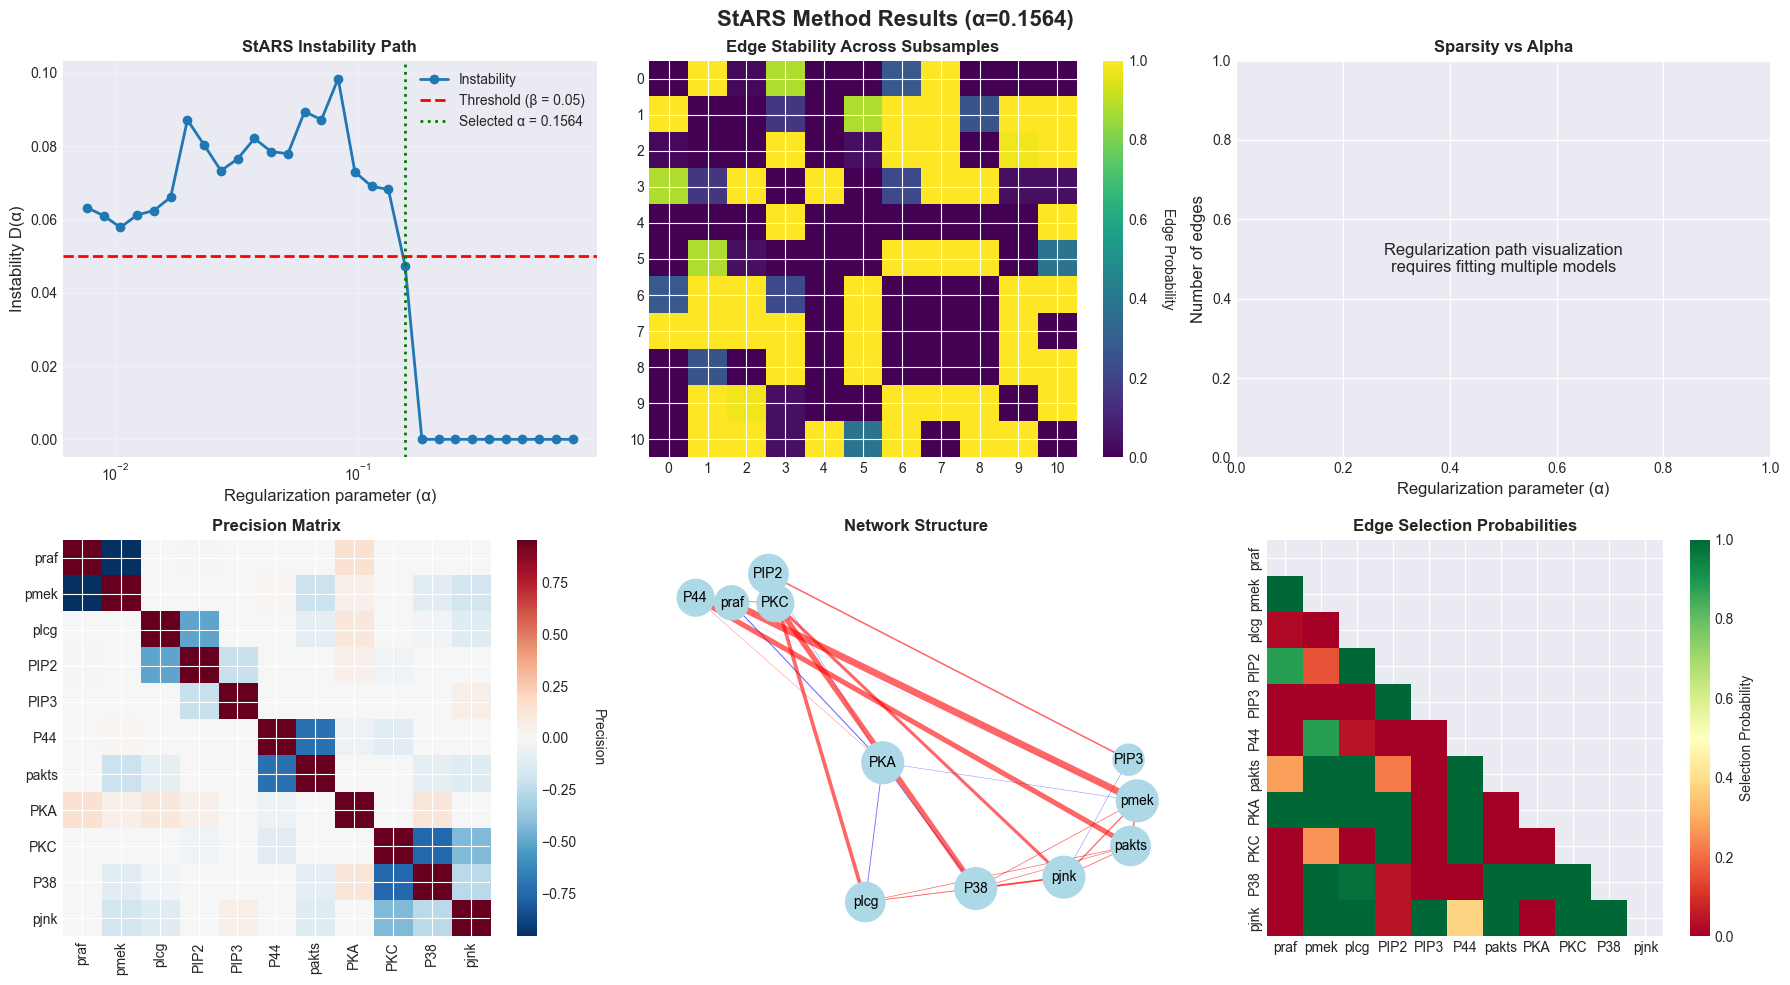

In [10]:
# Visualize StARS results
fig = plt.figure(figsize=(18, 10))

# StARS path
ax1 = plt.subplot(2, 3, 1)
plot_stars_path(model_stars, ax=ax1)
ax1.set_title('StARS Instability Path', fontsize=12, fontweight='bold')

# Edge stability
ax2 = plt.subplot(2, 3, 2)
plot_edge_stability(model_stars, ax=ax2)
ax2.set_title('Edge Stability Across Subsamples', fontsize=12, fontweight='bold')

# Regularization path
ax3 = plt.subplot(2, 3, 3)
plot_regularization_path(model_stars, ax=ax3)
ax3.set_title('Sparsity vs Alpha', fontsize=12, fontweight='bold')

# Precision matrix
ax4 = plt.subplot(2, 3, 4)
plot_precision_matrix(model_stars.precision_, labels=feature_names, ax=ax4)
ax4.set_title('Precision Matrix', fontsize=12, fontweight='bold')

# Network
ax5 = plt.subplot(2, 3, 5)
plot_network(model_stars.precision_, threshold=0.01, layout='spring',
            labels=feature_names, ax=ax5)
ax5.set_title('Network Structure', fontsize=12, fontweight='bold')

# Edge probability heatmap
ax6 = plt.subplot(2, 3, 6)
if hasattr(model_stars, 'edge_probs_') and model_stars.edge_probs_ is not None:
    mask = np.triu(np.ones_like(model_stars.edge_probs_, dtype=bool))
    sns.heatmap(model_stars.edge_probs_, mask=mask, cmap='RdYlGn', center=0.5,
               xticklabels=feature_names, yticklabels=feature_names,
               vmin=0, vmax=1, square=True, ax=ax6,
               cbar_kws={'label': 'Selection Probability'})
    ax6.set_title('Edge Selection Probabilities', fontsize=12, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'Edge probabilities\nnot available',
            ha='center', va='center', transform=ax6.transAxes, fontsize=14)
    ax6.axis('off')

plt.suptitle(f'StARS Method Results (α={model_stars.alpha_:.4f})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.2 EBIC Comprehensive Visualization

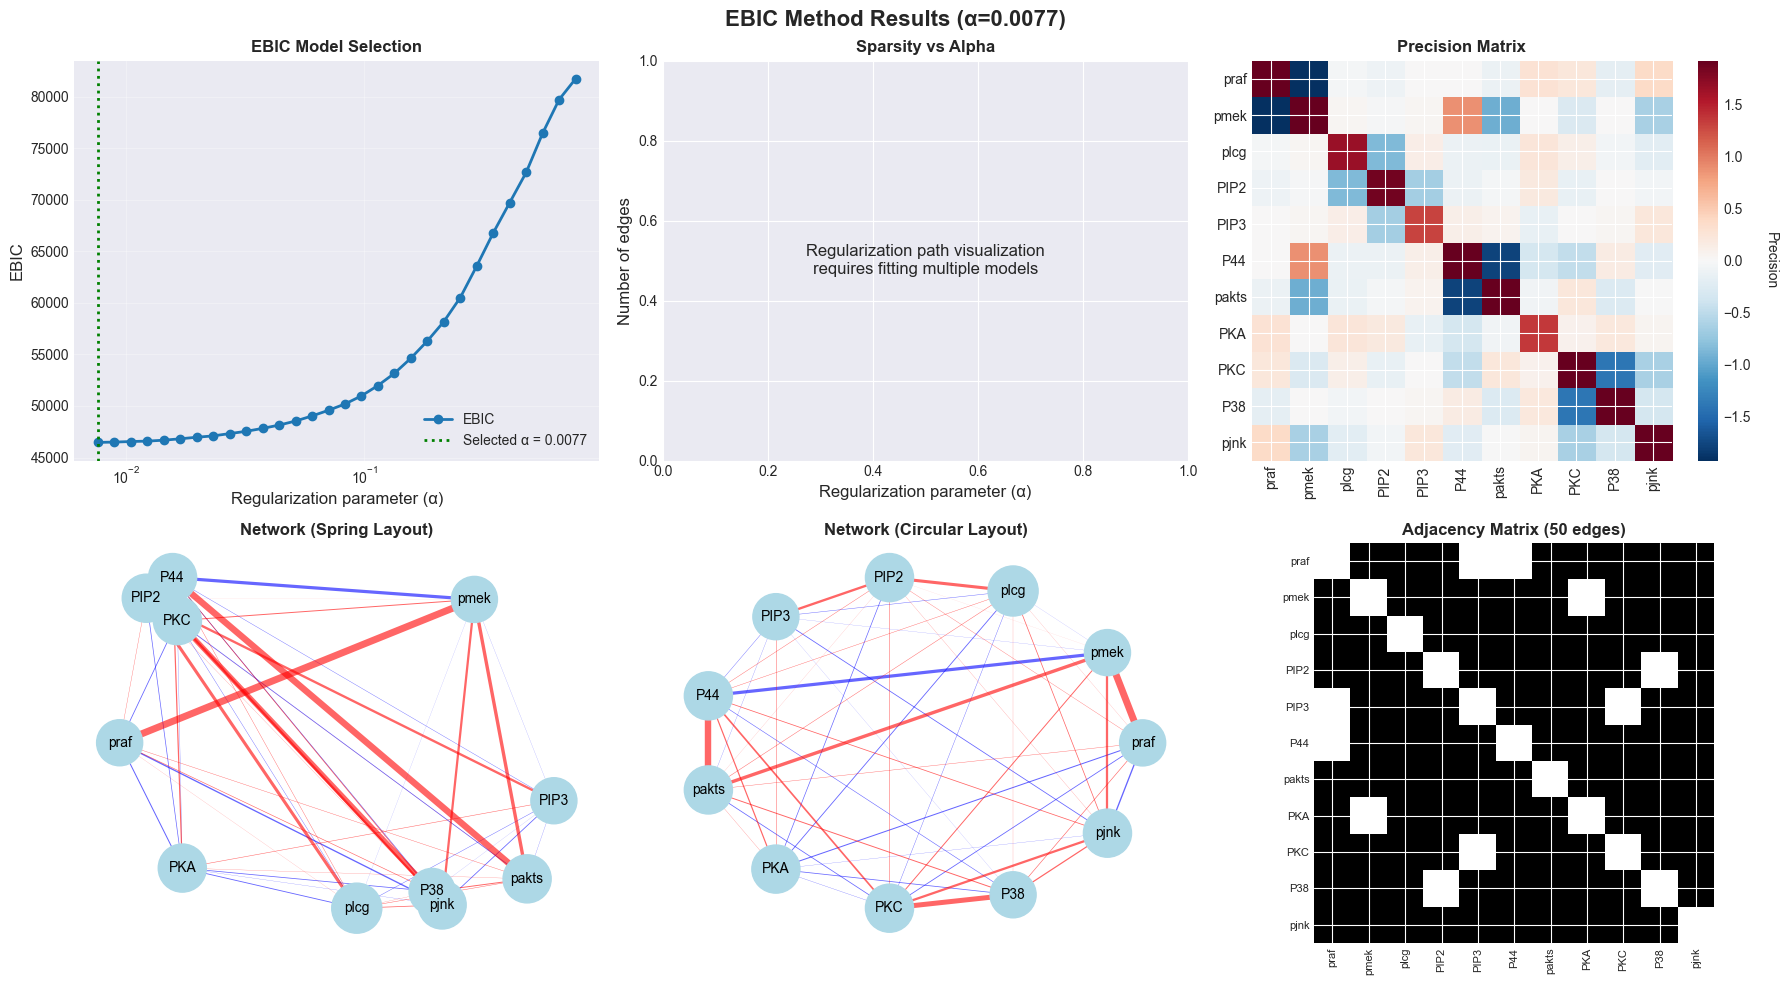

In [11]:
# Visualize EBIC results
fig = plt.figure(figsize=(18, 10))

# EBIC scores
ax1 = plt.subplot(2, 3, 1)
plot_model_selection(model_ebic, ax=ax1)
ax1.set_title('EBIC Model Selection', fontsize=12, fontweight='bold')

# Regularization path
ax2 = plt.subplot(2, 3, 2)
plot_regularization_path(model_ebic, ax=ax2)
ax2.set_title('Sparsity vs Alpha', fontsize=12, fontweight='bold')

# Precision matrix
ax3 = plt.subplot(2, 3, 3)
plot_precision_matrix(model_ebic.precision_, labels=feature_names, ax=ax3)
ax3.set_title('Precision Matrix', fontsize=12, fontweight='bold')

# Network (spring layout)
ax4 = plt.subplot(2, 3, 4)
plot_network(model_ebic.precision_, threshold=0.01, layout='spring',
            labels=feature_names, ax=ax4)
ax4.set_title('Network (Spring Layout)', fontsize=12, fontweight='bold')

# Network (circular layout)
ax5 = plt.subplot(2, 3, 5)
plot_network(model_ebic.precision_, threshold=0.01, layout='circular',
            labels=feature_names, ax=ax5)
ax5.set_title('Network (Circular Layout)', fontsize=12, fontweight='bold')

# Adjacency
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(model_ebic.adjacency_, cmap=ListedColormap(['white', 'black']),
          vmin=0, vmax=1, interpolation='none')
ax6.set_title(f'Adjacency Matrix ({model_ebic.n_edges_} edges)', 
             fontsize=12, fontweight='bold')
ax6.set_xticks(range(n_features))
ax6.set_yticks(range(n_features))
ax6.set_xticklabels(feature_names, rotation=90, fontsize=8)
ax6.set_yticklabels(feature_names, fontsize=8)

plt.suptitle(f'EBIC Method Results (α={model_ebic.alpha_:.4f})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.3 Cross-Validation Visualization

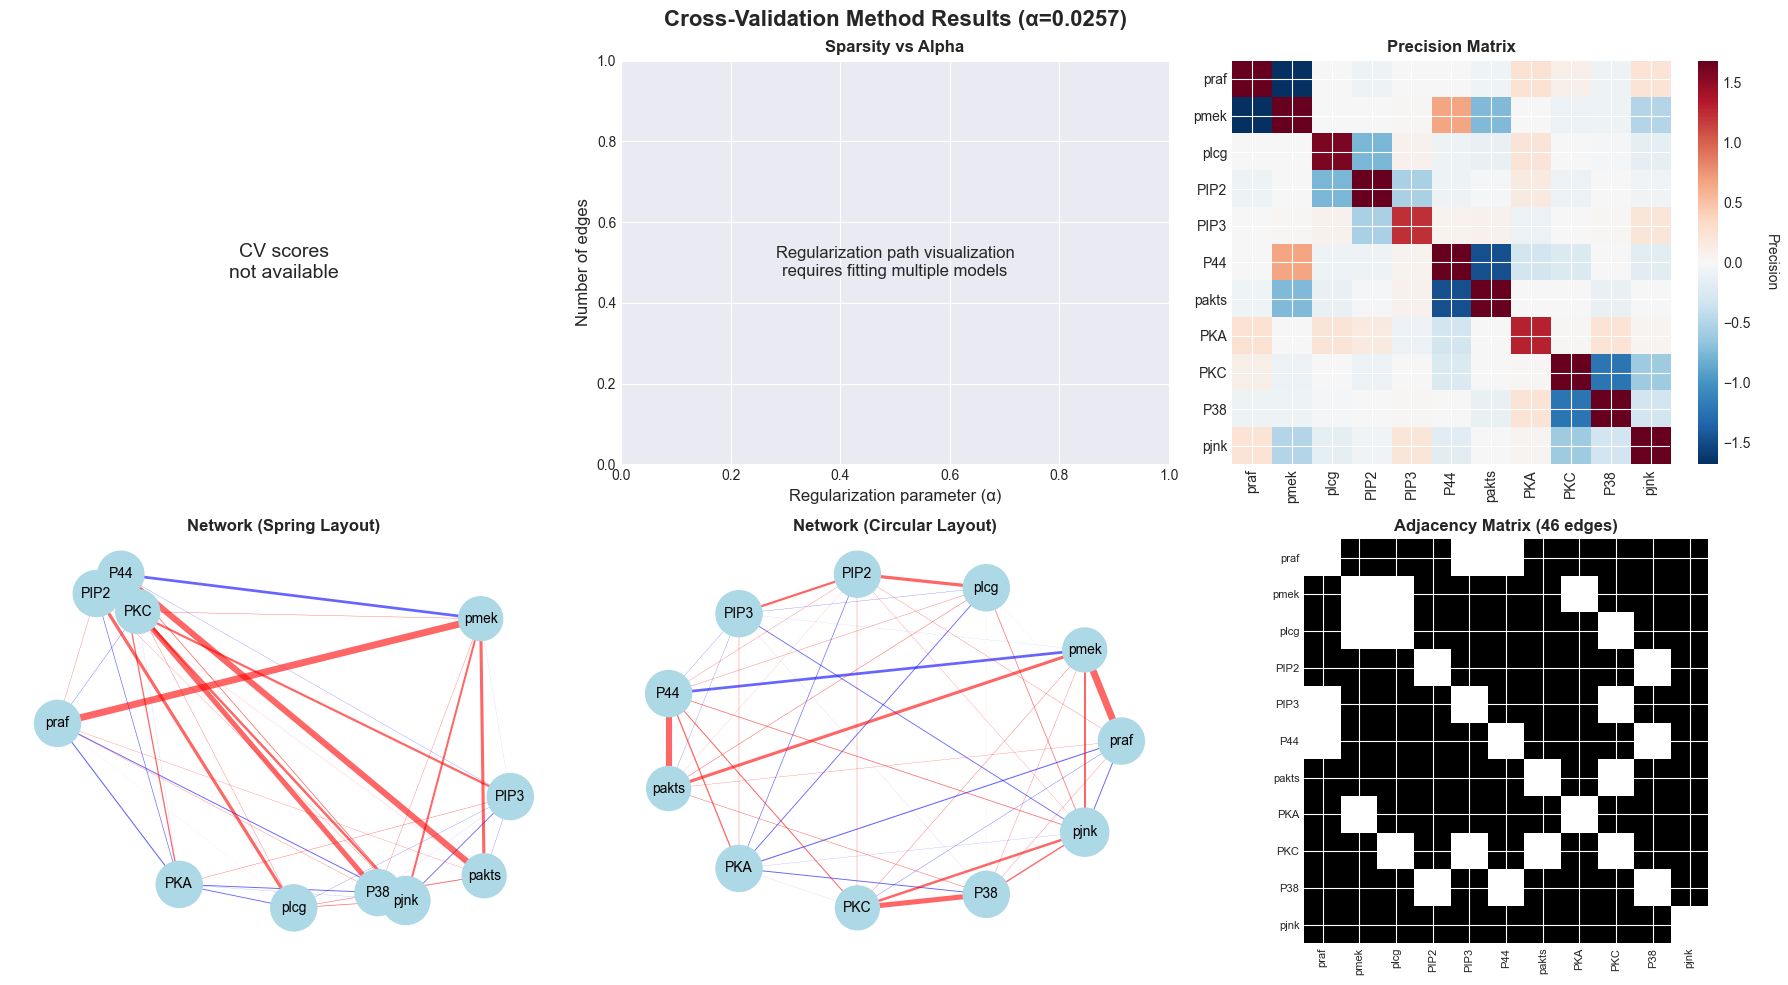

In [12]:
# Visualize CV results
fig = plt.figure(figsize=(18, 10))

# CV scores (if available)
ax1 = plt.subplot(2, 3, 1)
if (hasattr(model_cv, 'cv_scores_') and model_cv.cv_scores_ is not None and 
    len(model_cv.cv_scores_) > 0 and len(model_cv.cv_scores_) == len(model_cv.alphas_)):
    ax1.plot(model_cv.alphas_, model_cv.cv_scores_, 'o-', linewidth=2)
    ax1.axvline(model_cv.alpha_, color='red', linestyle='--', label=f'Selected α={model_cv.alpha_:.4f}')
    ax1.set_xlabel('Lambda (α)', fontsize=10)
    ax1.set_ylabel('CV Score', fontsize=10)
    ax1.set_title('Cross-Validation Scores', fontsize=12, fontweight='bold')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'CV scores\nnot available',
            ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax1.axis('off')

# Regularization path
ax2 = plt.subplot(2, 3, 2)
plot_regularization_path(model_cv, ax=ax2)
ax2.set_title('Sparsity vs Alpha', fontsize=12, fontweight='bold')

# Precision matrix
ax3 = plt.subplot(2, 3, 3)
plot_precision_matrix(model_cv.precision_, labels=feature_names, ax=ax3)
ax3.set_title('Precision Matrix', fontsize=12, fontweight='bold')

# Network (spring layout)
ax4 = plt.subplot(2, 3, 4)
plot_network(model_cv.precision_, threshold=0.01, layout='spring',
            labels=feature_names, ax=ax4)
ax4.set_title('Network (Spring Layout)', fontsize=12, fontweight='bold')

# Network (circular layout)
ax5 = plt.subplot(2, 3, 5)
plot_network(model_cv.precision_, threshold=0.01, layout='circular',
            labels=feature_names, ax=ax5)
ax5.set_title('Network (Circular Layout)', fontsize=12, fontweight='bold')

# Adjacency
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(model_cv.adjacency_, cmap=ListedColormap(['white', 'black']),
          vmin=0, vmax=1, interpolation='none')
ax6.set_title(f'Adjacency Matrix ({model_cv.n_edges_} edges)', 
             fontsize=12, fontweight='bold')
ax6.set_xticks(range(n_features))
ax6.set_yticks(range(n_features))
ax6.set_xticklabels(feature_names, rotation=90, fontsize=8)
ax6.set_yticklabels(feature_names, fontsize=8)

plt.suptitle(f'Cross-Validation Method Results (α={model_cv.alpha_:.4f})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<a id='fixed-alpha'></a>
## 6. Fixed Alpha Analysis

Let's see how the network changes with different fixed alpha values.

In [13]:
# Test different fixed alpha values
alphas_fixed = [0.001, 0.1, 0.5]

models_fixed = []
print("Testing fixed alpha values on NPN-transformed data:\n")
for alpha in alphas_fixed:
    model = GaussianGraphicalModel(alpha=alpha, verbose=0)
    model.fit(X_transformed)  # ← Using TRANSFORMED data!
    models_fixed.append(model)
    print(f"α = {alpha:5.3f}: {model.n_edges_:3d} edges, "
          f"density = {model.n_edges_/(n_features*(n_features-1)/2):.1%}")

Testing fixed alpha values on NPN-transformed data:

α = 0.001:  54 edges, density = 98.2%
α = 0.100:  33 edges, density = 60.0%
α = 0.500:   6 edges, density = 10.9%


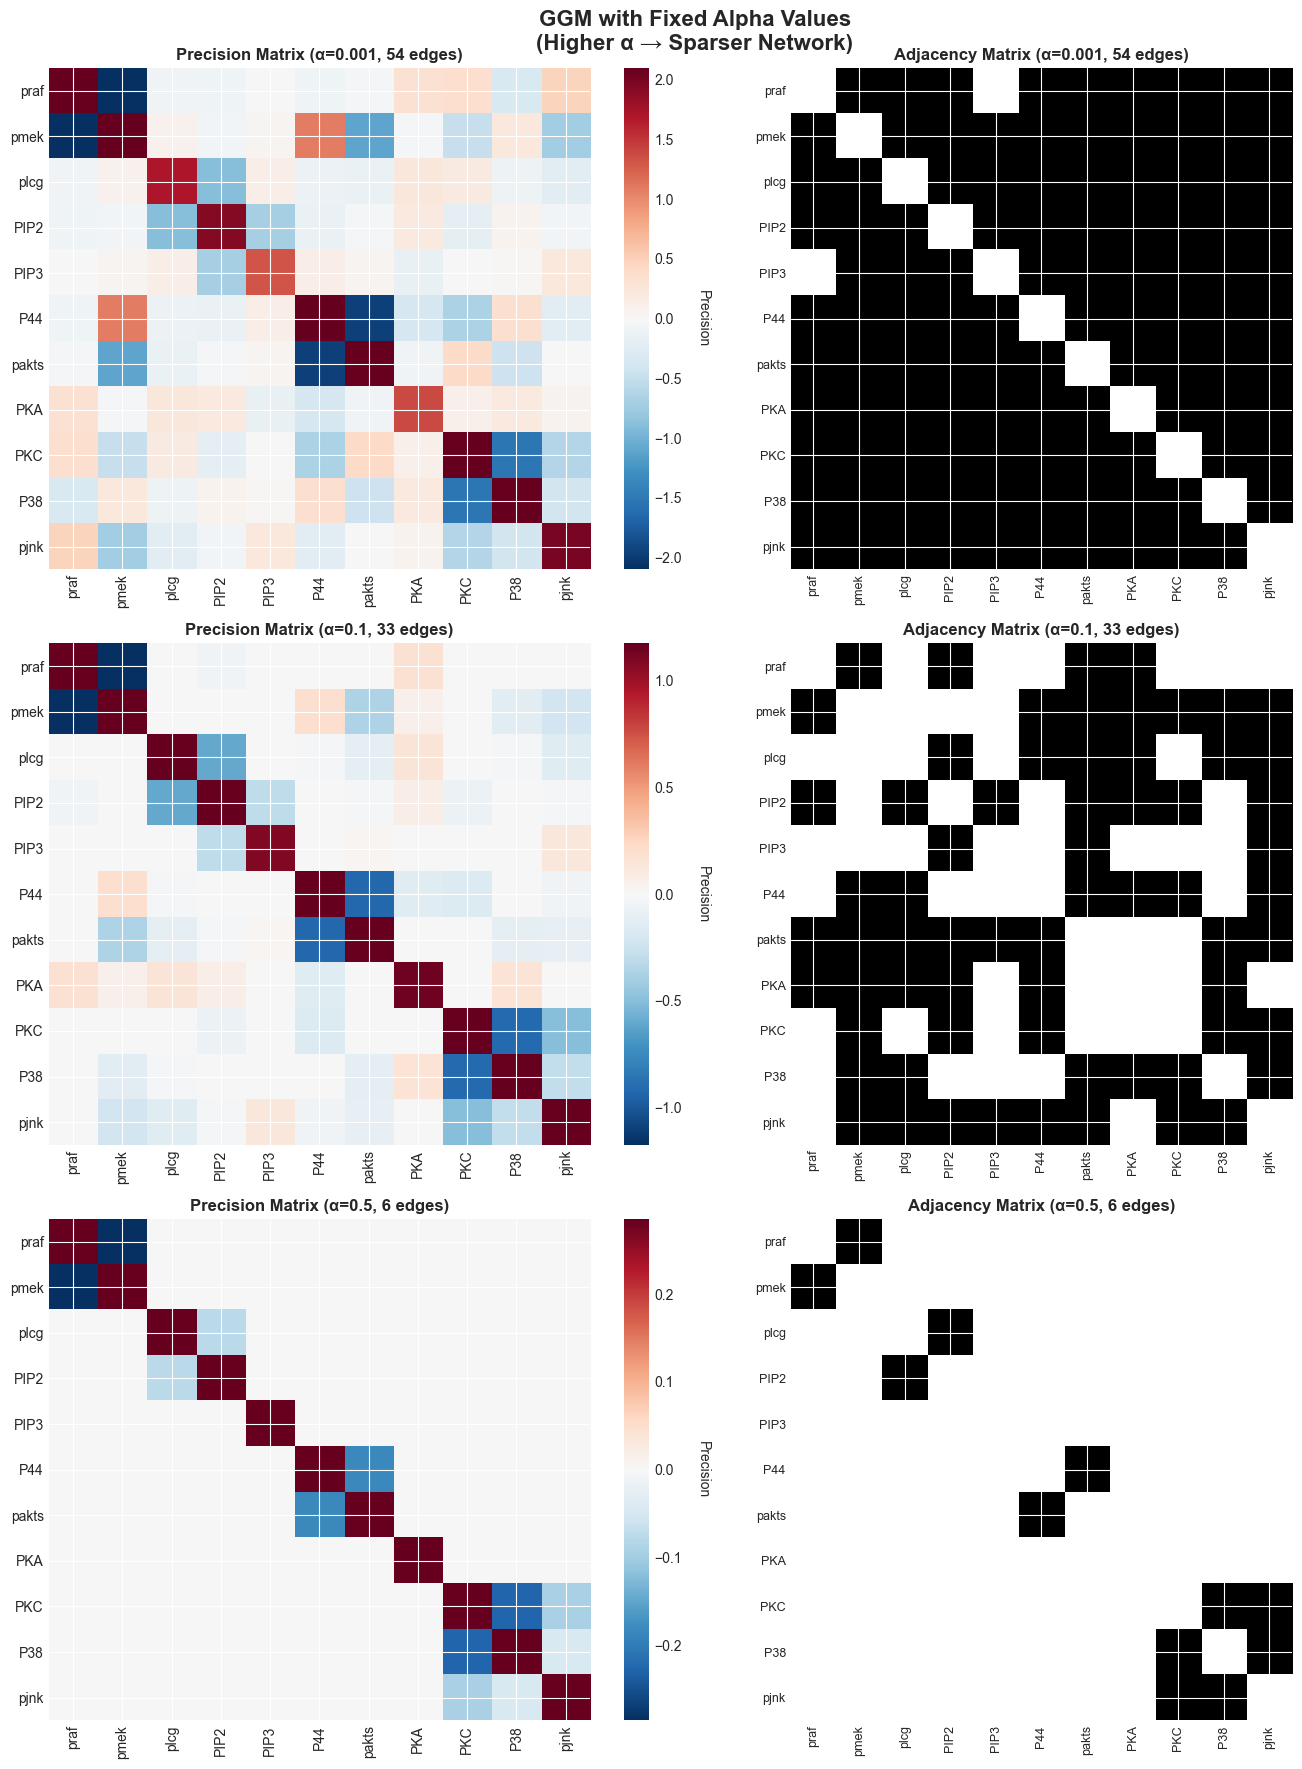


✓ As α increases, network becomes sparser (fewer edges)


In [14]:
# Visualize fixed alpha comparison
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
cmap_bw = ListedColormap(['white', 'black'])

for i, (model, alpha) in enumerate(zip(models_fixed, alphas_fixed)):
    # Precision matrix
    plot_precision_matrix(model.precision_, labels=feature_names, ax=axes[i, 0])
    axes[i, 0].set_title(f'Precision Matrix (α={alpha}, {model.n_edges_} edges)', 
                        fontsize=12, fontweight='bold')
    
    # Adjacency matrix
    axes[i, 1].imshow(model.adjacency_, cmap=cmap_bw, vmin=0, vmax=1, interpolation='none')
    axes[i, 1].set_title(f'Adjacency Matrix (α={alpha}, {model.n_edges_} edges)',
                        fontsize=12, fontweight='bold')
    axes[i, 1].set_xticks(range(n_features))
    axes[i, 1].set_yticks(range(n_features))
    axes[i, 1].set_xticklabels(feature_names, rotation=90, fontsize=9)
    axes[i, 1].set_yticklabels(feature_names, fontsize=9)

plt.suptitle('GGM with Fixed Alpha Values\n(Higher α → Sparser Network)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ As α increases, network becomes sparser (fewer edges)")

<a id='bootstrap'></a>
## 7. Bootstrap Stability Analysis

Test edge stability using bootstrap resampling at a fixed alpha.

In [15]:
# Bootstrap stability for a fixed alpha
print("Performing bootstrap stability analysis...\n")
print(f"Using α = {model_ebic.alpha_:.6f} (from EBIC)")
print(f"Number of bootstrap samples: 100\n")

B = 100
rng = np.random.RandomState(42)
eps = 1e-8
sel_counts = np.zeros((n_features, n_features), dtype=float)

for b in range(B):
    if (b + 1) % 20 == 0:
        print(f"  Bootstrap {b+1}/{B}...")
    
    # Bootstrap sample
    idx = rng.randint(0, n_samples, size=n_samples)
    X_boot = X_transformed[idx]  # ← Using TRANSFORMED data!
    
    # Fit model
    model_boot = GaussianGraphicalModel(alpha=model_ebic.alpha_, verbose=0)
    model_boot.fit(X_boot)
    
    # Count edges
    A_boot = (np.abs(model_boot.precision_) > eps).astype(int)
    np.fill_diagonal(A_boot, 0)
    A_boot = np.maximum(A_boot, A_boot.T)
    sel_counts += A_boot

# Selection frequency
freq = sel_counts / B
np.fill_diagonal(freq, 0.0)

print(f"\nBootstrap analysis complete!")
print(f"  Frequency range: {freq[freq>0].min():.2f} to {freq.max():.2f}")

Performing bootstrap stability analysis...

Using α = 0.007655 (from EBIC)
Number of bootstrap samples: 100

  Bootstrap 20/100...
  Bootstrap 40/100...
  Bootstrap 60/100...
  Bootstrap 80/100...
  Bootstrap 100/100...

Bootstrap analysis complete!
  Frequency range: 0.06 to 1.00


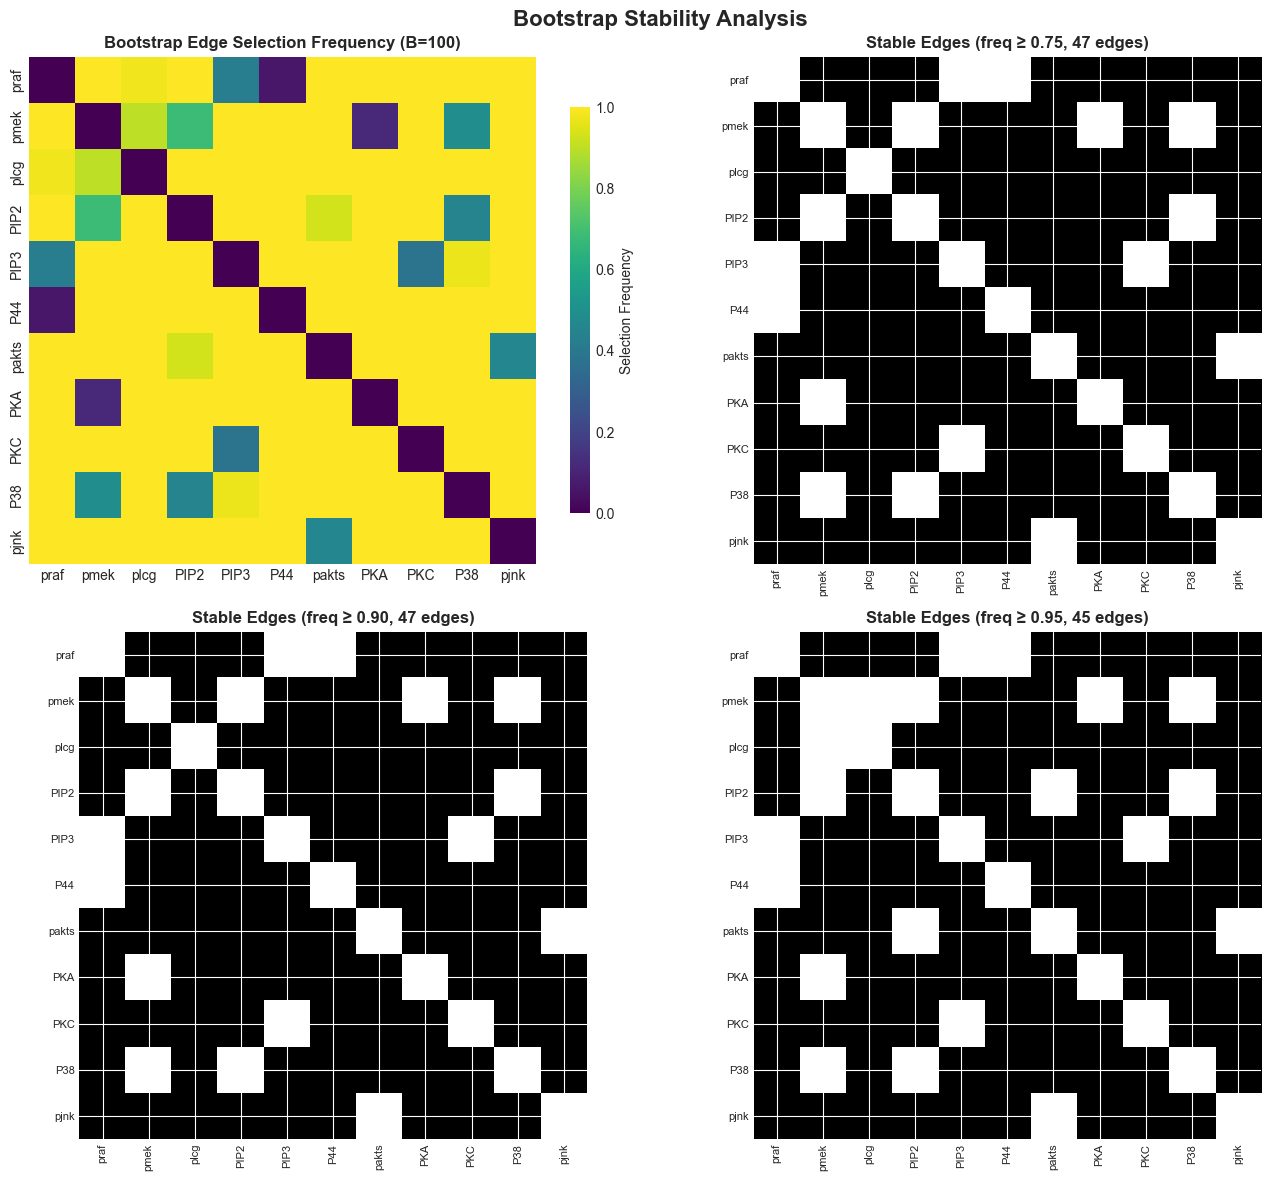


Interpretation:
  - High frequency (bright yellow) = Very stable edge
  - Low frequency (dark blue) = Unstable edge
  - Use high threshold (e.g., 0.95) for most confident edges


In [16]:
# Visualize bootstrap stability
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
cmap_bw = ListedColormap(['white', 'black'])

# Selection frequency heatmap
sns.heatmap(freq, vmin=0, vmax=1, cmap='viridis', square=True,
           xticklabels=feature_names, yticklabels=feature_names,
           cbar_kws={'shrink': 0.8, 'label': 'Selection Frequency'},
           ax=axes[0, 0])
axes[0, 0].set_title('Bootstrap Edge Selection Frequency (B=100)', 
                    fontsize=12, fontweight='bold')

# Stable edges at different thresholds
thresholds = [0.75, 0.90, 0.95]
for idx, thr in enumerate(thresholds):
    A_stable = (freq >= thr).astype(int)
    np.fill_diagonal(A_stable, 0)
    A_stable = np.maximum(A_stable, A_stable.T)
    n_edges = int(np.sum(np.triu(A_stable, 1)))
    
    ax = axes.ravel()[idx + 1]
    ax.imshow(A_stable, cmap=cmap_bw, vmin=0, vmax=1, interpolation='none')
    ax.set_title(f'Stable Edges (freq ≥ {thr:.2f}, {n_edges} edges)',
                fontsize=12, fontweight='bold')
    ax.set_xticks(range(n_features))
    ax.set_yticks(range(n_features))
    ax.set_xticklabels(feature_names, rotation=90, fontsize=8)
    ax.set_yticklabels(feature_names, fontsize=8)

plt.suptitle('Bootstrap Stability Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - High frequency (bright yellow) = Very stable edge")
print("  - Low frequency (dark blue) = Unstable edge")
print("  - Use high threshold (e.g., 0.95) for most confident edges")